# Tutorial for training and testing NN-NMR model

Using P2-type Na<sub>2/3</sub>(Mg<sub>1/3</sub>Mn<sub>2/3</sub>)O<sub>2</sub> as an example, 1000 configurations extracted from two 200ns DPMD trajectories of *P*6<sub>3</sub>/*mcm* and *P*6<sub>3</sub>22 supercell models, 16000 <sup>23</sup>Na shifts.


## Install

The version of Tensorflow is depended by CUDA

In [ ]:
import sys
!{sys.executable} -m pip install -r requirements.txt

## Library and Environment

In [1]:
# Importing libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from tensorflow import keras
from ase.io import read
from nn_nmr import NMRModel, get_df_from_outcars

2022-02-23 22:18:12.497587: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
/home/aiida_test/env/py37/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [2]:
# Defining work directory
WORKDIR ='./'

# Defining the machine, GPU card
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4470008899836457317
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9876556813150652340
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 7361630035515429175
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9689483200
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15718346109562702488
physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5"
]


2022-02-23 22:18:15.756322: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-23 22:18:15.773530: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2300000000 Hz
2022-02-23 22:18:15.776081: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5635a81cc460 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-02-23 22:18:15.776142: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-02-23 22:18:15.783290: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-02-23 22:18:16.054300: I tensorflow/compiler/xla/service/service.cc

## From OUTCAR to SOAP descriptors and chemical shifts

- input: 
    - OUTCAR
    - expression
    - elements


- output: 
    - DataFrame(X: soaps, y: FCShifts)

In [3]:
# Defining SOAP parameters
expression = "soap cutoff=5.5 cutoff_transition_width=0.5 n_max=9 l_max=9 atom_sigma=0.55 n_Z=1 n_species=4 species_Z={11, 12, 25, 8}"
elements = ['Na']

# Getting data from many OUTCARs
folders = ['./p63mcm/', './p6322/']
df_all = pd.DataFrame()
for foldername in folders:
    outcar_list = os.listdir(foldername)
    outcar_list.sort(key=lambda x: int(x.lstrip('OUTCAR')))
    df_tmp = get_df_from_outcars([os.path.join(foldername, outcar) for outcar in outcar_list], expression=expression, elements=elements)
    df_all = pd.concat([df_all, df_tmp])
df_all

,X,y
0,"[0.06860095117868371, 1.4376865277355845e-08, ...",707.345735
1,"[0.06039654417031628, 1.213281348026635e-08, 1...",2132.439348
2,"[0.06803802894283517, 3.425563452549015e-08, 2...",1019.410030
3,"[0.060121523316184915, 3.0016900889318795e-08,...",2206.854680
4,"[0.0698653952573221, 6.2719541058041445e-09, 2...",488.900729
...,...,...
7995,"[0.06059652226968546, 1.1072131640138081e-08, ...",2754.167443
7996,"[0.06273516264810623, 7.46626163061316e-08, 3....",2146.042151
7997,"[0.0598401274934071, 3.5565748352019324e-08, 3...",2384.491279
7998,"[0.060939281084748026, 5.289879195148565e-08, ...",1899.591374


## Training and testing the NN-NMR model

- input: 
    - data(DataFrame)


- output files stored in '{WORKDIR}/results/': 
    - model: stored in 'model_test'
    - test set information after training: stored in 'rmse_and_test_data.npy'. key-'test_y' shows chemical shifts of training set; key-'test_y_pred' shows predicted values of chemical shifts corresponding to the key-'test_y'; key-'rmse' shows the value of rmse between key-'test_y' and key-'test_y_pred'
    - training history: stored in 'model_test_hist.pkl'

In [4]:
# Training the NN-NMR model
X, y = NMRModel.get_Xy_from_df(df_all) # get X and y data from sampled data
history = NMRModel(X, y).train_model(epochs=1000, filename=f'{WORKDIR}/results/model_test')

2022-02-23 22:20:09.991591: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:1a:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-23 22:20:09.991710: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-02-23 22:20:09.991763: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-02-23 22:20:09.991788: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-02-23 22:20:09.991809: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcurand.so.10
2022-02-23 22:20:09.991826: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcusolv

Training:   0%|           0/1000 ETA: ?s,  ?epochs/s

2022-02-23 22:20:12.961261: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


2022-02-23 22:28:24.382720: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: .//results/model_test/assets


In [6]:
# Extracting information from data generated during NN-NMR model training
test_data = np.load(f'{WORKDIR}/results/rmse_and_test_data.npy', allow_pickle=True)
test_data = test_data.tolist() 
test_data

{'rmse': 107.66906716153294,
 'test_y': array([2360.48633301, 2688.55392506, 1591.52790385, ..., 2030.81841125,
         847.37458531, 1574.72444182]),
 'test_y_pred': array([2288.3352 , 2723.762  , 1634.6884 , ..., 1969.8505 ,  838.94586,
        1532.5627 ], dtype=float32)}

RMSE: 107.66906716153294
R^2: 0.9696497473159182


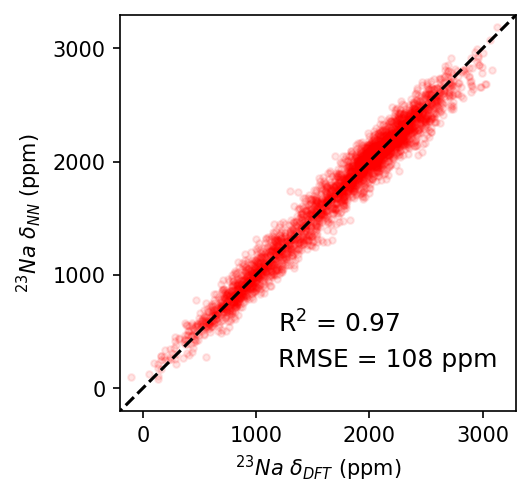

In [7]:
# RMSE and R2
rmse_test = test_data['rmse']
print(f'RMSE: {rmse_test}')
R2 = r2_score(test_data['test_y'], test_data['test_y_pred'])
print(f'R^2: {R2}')

# Plotting the correlation of 23Na shift calculated with DFT and with NN-NMR model
fig, ax = plt.subplots(figsize=(3.5, 3.5), dpi=150)
ax.scatter(test_data['test_y'], test_data['test_y_pred'], alpha=0.1, s=10, c='r')

ax.text(min(test_data['test_y'])+1300, min(test_data['test_y'])+300, "RMSE = " + "%.0f"%(rmse_test)+' ppm', fontsize = 12)
ax.text(min(test_data['test_y'])+1300, min(test_data['test_y'])+600, "R$^{2}$ = " + "%.2f"%(R2), fontsize = 12)

ax.set_xlabel('$^{23}Na$ $\delta_{DFT}$ (ppm)')
ax.set_ylabel('$^{23}Na$ $\delta_{NN}$ (ppm)')
ax.axis('equal')
ax.axis('square')   
plt.xticks(np.arange(0,3500,1000))
plt.yticks(np.arange(0,3500,1000))
plt.xlim([-200,3300])
plt.ylim([-200,3300])
_ = ax.plot([-10000, 10000], [-10000, 10000], c='k', ls='--')

#plt.savefig(foldername+'correlation.jpg', dpi = 400, bbox_inches = 'tight')

             loss        mae           mse      val_loss    val_mae  \
995  14748.811523  95.186409  14551.958984  12242.406250  86.886452   
996  14551.865234  94.131195  14354.973633  13718.766602  92.638206   
997  14819.332031  95.499115  14622.407227  12198.987305  86.231110   
998  14577.164062  94.389412  14380.214844  12094.952148  85.922264   
999  14523.681641  94.604492  14326.699219  11789.624023  84.885368   

          val_mse  epoch  
995  12045.503906    995  
996  13521.824219    996  
997  12002.062500    997  
998  11897.990234    998  
999  11592.629883    999  


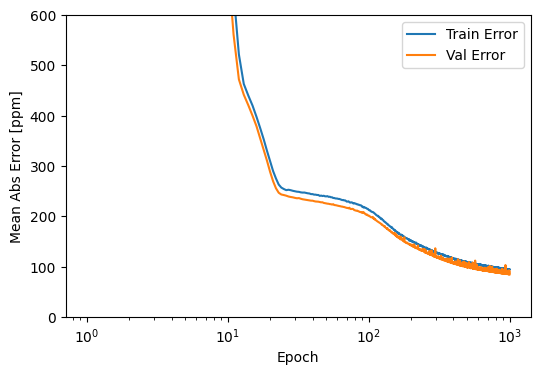

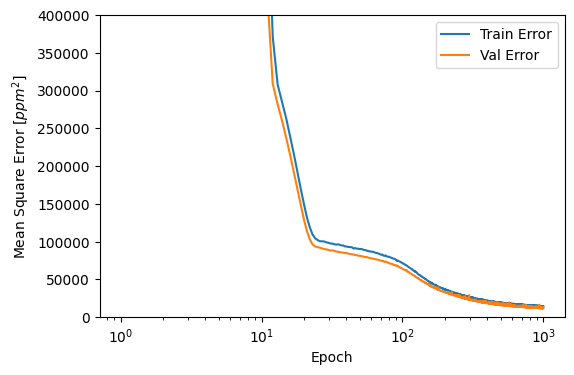

In [8]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    print(hist.tail())
    
    plt.figure(dpi=100)
    plt.xlabel('Epoch')
    plt.xscale('log')
    plt.ylabel('Mean Abs Error [ppm]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label = 'Val Error')
    plt.ylim([0,600])
    plt.legend()

    plt.figure(dpi=100)
    plt.xlabel('Epoch')
    plt.xscale('log')
    plt.ylabel('Mean Square Error [$ppm^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.ylim([0,400000])
    plt.legend()
    plt.show()

plot_history(history)

## Predict

- input:
    - model
    - atoms
    - expression
    - elements


- output:
    - chemical shifts


The script for generating chemical shifts in batches on HPC is shown in 'gpu.py' and 'gpu.lsf'

In [9]:
test_atoms = read('predict_fcshifts_example.xyz')
nmr = NMRModel()
nmr.load_model(f'{WORKDIR}/results/model_test')
chemical_shifts = nmr.predict_fcshifts(test_atoms, expression=expression, elements=elements)
print(chemical_shifts)

[2137.0222  1883.9594   593.6657  2092.7043  2041.4454  2358.133
 2361.4194   998.18567 1038.0332   823.92413  629.6751  2642.8796
 1396.8855  2301.2632  1813.4369  2152.8196 ]
